# 1. Introduction 

In a world of ubiquitous digital color grading, certain artistic choices can seem to be repeated ad nauseam in blockbuster movies. Specifically, the orange and teal color palette is especially prevalent in the industry. In films like Mad Max: Fury Road and Transformers 2 the color palette is a cornerstone of the film's cinematography. 

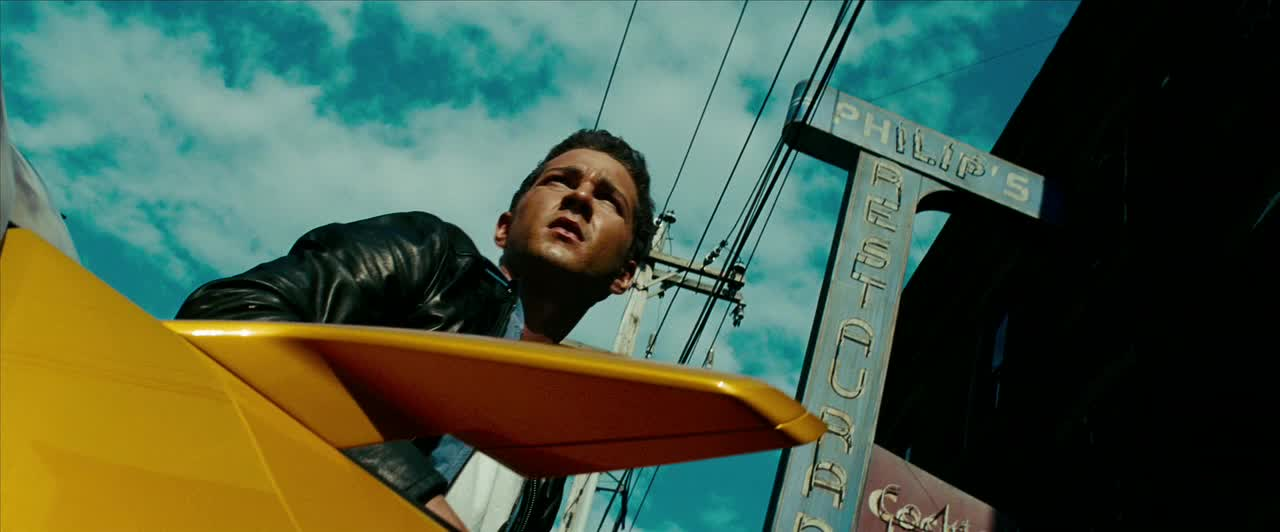
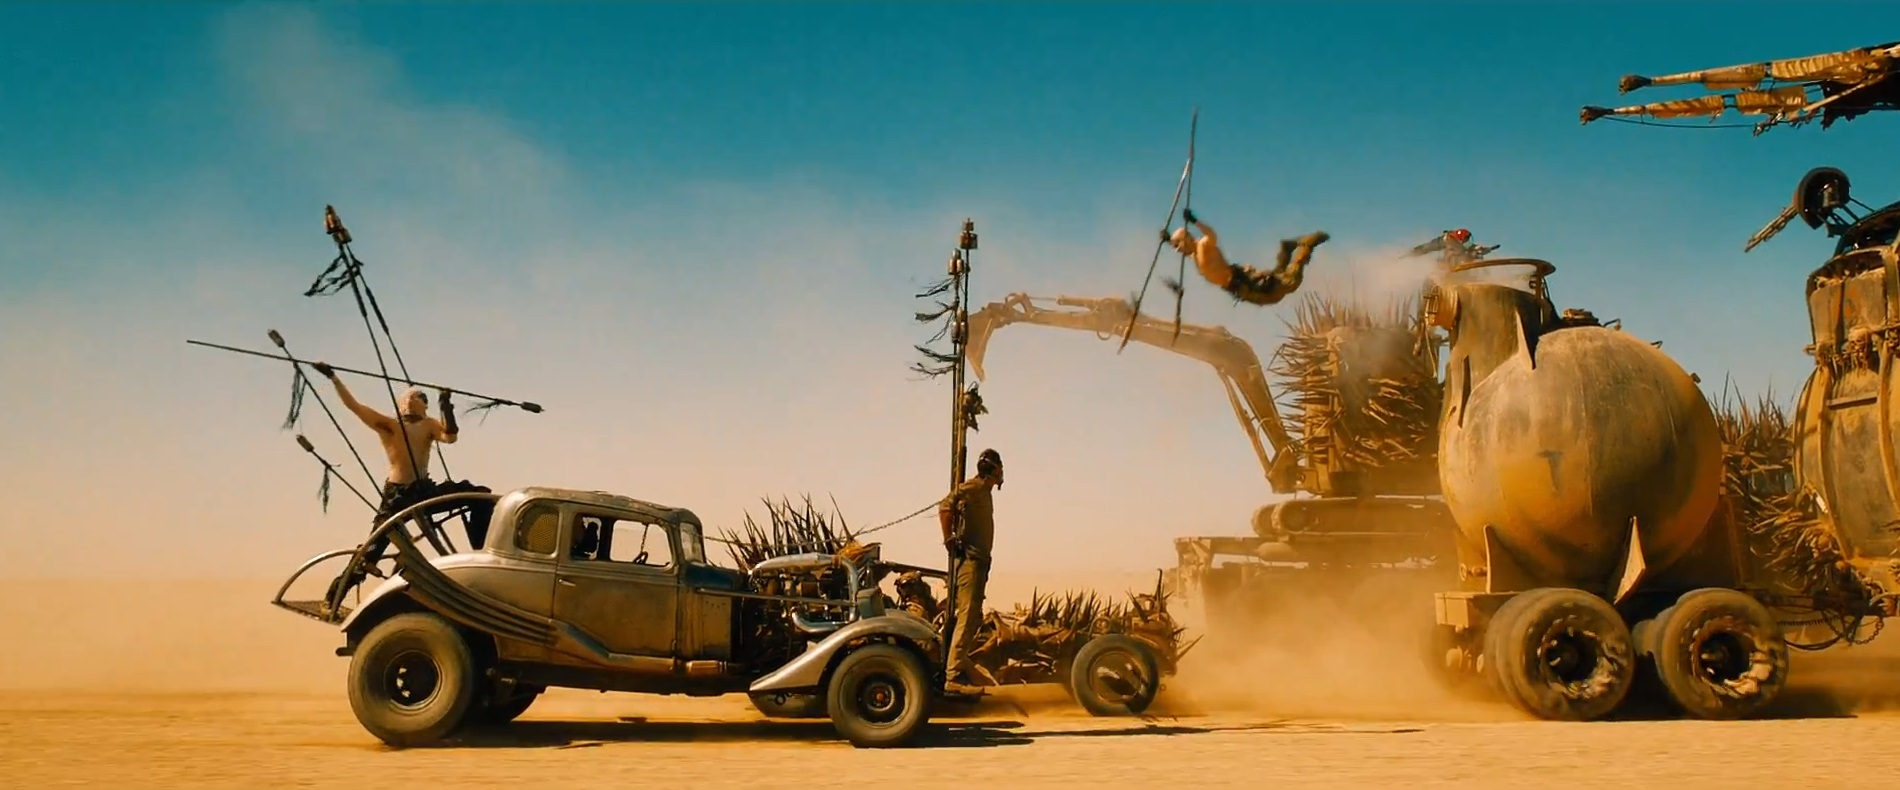

The goal of this notebook is to research this trend further, to limit the search to more manageable levels, I will be focusing on action movies of the past twenty years. A sample of movies will be taken and analyzed to find if there is a trend in the usage of specific color palettes. 

To help us research this question further, I develop image analysis algorithms to extract dominant colors in film frames. These will be part of a larger video analysis algorithm that will extract the dominant colors of entire films. 

Finally, these techniques will be applied to dozens of movie trailers to potentially find patterns in color palette usage.


# 2. Extraction of dominant colors in a video

In order to extract dominant colors from videos we must first be able to extract them from single frames. In this section we take an iterative approach and build an increasingly more sophisticated algorithm. 

## References 

I took inspiration from several sources during the making of this notebook. Some are cited directly in the paragraphs bellow, but I want to highlight the [wikipedia page](https://en.wikipedia.org/wiki/K-means_clustering) for K-means clustering, which helped me re-familiarize myself with the technique. Additionally, this [blogpost](https://tatasz.github.io/dominant_colors/) was in interesting read from which I took inspiration and this [paper](https://ieeexplore.ieee.org/abstract/document/9869653/citations#citations) helped me understand types of advanced methods that were at my disposal.  





## Extraction of dominant frame colors through average color analysis 

Let us create a simple algorithm that receives an image and calculates the average color of all pixels and run it by some sample images.

In [ ]:
from pathlib import Path
from PIL import Image
from IPython.display import display
import numpy as np

notebook_dir = Path().resolve()
image_location = notebook_dir / 'frames'

for image_path in sorted(image_location.glob('*.jpg')):  

    # import, open and display images
    img = Image.open(str(image_path))
    display(img)
    
    # convert the image to a NumPy array and find mean pixel color
    img_array = np.array(img)
    average_color = img_array.mean(axis=(0, 1))
    print(f'Average color (R, G, B): {average_color}')
    
    # Display average color
    average_color_image = Image.new('RGB', (300, 100), tuple(map(int, average_color)))
    display(average_color_image)


This algorithm is not very accurate. The first two images are rather monochromatic. One is mostly composed of greys and the other of orange tones. In both, the average pixel color is only vaguely representative of the actual most noticeable tonalities in the images. Even worse, when used in pictures with contrasting colors, the average color does not represent any color properly.  

The next step is improving the algorithm such that more than one dominant color can be identified. To do this, we will use a k means clustering algorithm. This will allow us to find groups of similar colors and calculate the means of those groups. 

The following code uses [this](https://scikit-learn.org/stable/modules/clustering.html#k-means) machine learning library and its K-means implementation. It is important to note that this implementation is _not deterministic_, and so results may vary. 

In [ ]:
from pathlib import Path
from PIL import Image
from IPython.display import display
import numpy as np
from sklearn.cluster import KMeans # had some trouble importing, numpy must be v1.x

notebook_dir = Path().resolve()
image_location = notebook_dir / 'frames'

def kmeans(k, image_path, display_frames=True): 
    # import, open and display images
    img = Image.open(str(image_path))
    if display_frames: 
        display(img)
    
    # convert image to array of pixels
    pixels = np.array(img).reshape(-1, 3)

    # perform k-means
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_

def print_colors(colors): 
    print(f'Dominant colors (R, G, B): \n {colors}')
    dominant_color_images = [Image.new('RGB', (300, 100), tuple(map(int, color))) for color in colors]
    for color_image in dominant_color_images:
        display(color_image)

for image_path in sorted(image_location.glob('*.jpg')): 
    print_colors(kmeans(2, image_path))

This is slightly better. There were improvements in the monochromatic images, with a clearer and accurate distinction between the shades. However, the bi-color images continue to have inaccurate results, with clearly prominent colors not being detected. 

Let us increase the number of clusters used in the algorithm. 

In [ ]:
for image_path in sorted(image_location.glob('*.jpg')): 
    print_colors(kmeans(5, image_path))

Much better! In the bi-color frames, we now have a color palette representative of the images. All main colors are present, the orange and teal pattern is clear, just like the red and green. It is important to note that adding more clusters did not add much information to the monochromatic frame results. In fact, the white result for the second image might even be misleading. 

Since we want to investigate prominent *color* combinations in film, black and white color results do not interest us much. Additionally, 5 clusters does give us all dominant colors in the images, but it also provides several shades of the same color. In order to trim down the results to two main colors, we can eliminate very dark or bright shades, and focus on keeping colors that are substantially different from each other (ex. light and deep red vs yellow and pink).

The following are some functions that will help us implement these restrictions: 

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean

def is_valid_color(color, min_brightness=40, max_brightness=215):
    brightness = np.mean(color)
    return min_brightness <= brightness <= max_brightness

def color_distance(color1, color2):
    return euclidean(color1, color2)

def select_distinct_colors(colors, n=2):
    # filter very dark or bright colors
    valid_colors = [color for color in colors if is_valid_color(color)]
    
    #if all colors are dark and bright, choose from among them
    if len(valid_colors) < n:
        valid_colors = colors

    # if only two valid colors, return them directly
    if len(valid_colors) == n:
        return valid_colors

    # find the two most distinct colors 
    max_distance = 0
    color_pair = None
    for i in range(len(valid_colors)):
        for j in range(i + 1, len(valid_colors)):
            distance = color_distance(valid_colors[i], valid_colors[j])
            if distance > max_distance:
                max_distance = distance
                color_pair = (valid_colors[i], valid_colors[j])
    
    return color_pair

select_distinct_colors() eliminates shades that are too bright or too dark, additionally it performs the selection of the two most distinct colors out of the group. There are three main adjustable parameters: min_brightness, max_brightness and the k value (number of clusters) when the k-means algorithm is called. Feel free to experiment with them. I have found that setting (k=7, min_brightness=40, max_brightness=215) yields good results. 

In [ ]:
for image_path in sorted(image_location.glob('*.jpg')): 
    print_colors(select_distinct_colors(kmeans(7, image_path)))

We now have very good representations of the dominant colors in the images. In the bi-color frames the teal and orange patters are obvious, and the red and green one is extremely appropriate, notice how the strongest, most representative, red shade was chosen. 

In the monochrome images, the elimination of the brightest and darkest tones is evident, allowing the algorithm to select more midrange tones, which better represent the dominant colors in the image. 

## Extraction of the dominant colors of a video

Now that we are able to extract the dominant colors from an image, the next step is doing the same to a full video. To do so, we must be able to extract frames from videos so that individual image analysis may take place.

The following function extracts frames from a certain video, at a specific time interval, and places them in the desired folder. 

In [ ]:
import cv2

def extract_frames(video_path, output_folder, frame_interval=5):
    # open video file
    video_capture = cv2.VideoCapture(video_path)
    if not video_capture.isOpened():
        print("Error: Could not open video.")
        return

    # get video fps and find number of frames per time interval
    fps = int(video_capture.get(cv2.CAP_PROP_FPS))
    interval_frame_number = frame_interval * fps

    frame_count = 0
    saved_frame_count = 0

    # iterate over frames and extract some
    while True:
        success, frame = video_capture.read()
        if not success:
            break

        if frame_count % interval_frame_number == 0:
            frame_filename = output_path / f"frame_{saved_frame_count:04d}.jpg"
            cv2.imwrite(frame_filename, frame)
            saved_frame_count += 1

        frame_count += 1

    video_capture.release()
    print(f"Extracted {saved_frame_count} frames from the video.")


# Example usage
notebook_dir = Path().resolve()
video_path = notebook_dir / 'test_trailer/madmax.mp4'
output_path = notebook_dir / 'test_trailer/frames'
extract_frames(video_path, output_path)

This algorithm works well when blindly extracting frames from a video. However, after running it on the test Mad Max trailer, a couple of details become noticeable. 

First, some frames are entirely black, or, at least, mostly made up of dark shadows. These should not count towards the color palette of the entire video. We will fix this by finding the mean pixel value of the frame, and discarding the frame if the value is too low. 

Secondly, some frames are advertisements for the movie, and not part of the movie themselves. We will correct this by ignoring the first and last 17 seconds of the trailer. 

Finally, there are black stripes above and bellow the image, these need to be removed. 

The following script implements these changes: 

In [ ]:
def frame_is_not_too_dark(frame): 
    img_array = np.array(frame)
    average_color = img_array.mean(axis=(0, 1))
    brightness = np.mean(average_color)
    return 20 < brightness 

def cut_out_black_stripes(frame):
    img_array = np.array(frame)
    
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    
    # find first row from top and bottom that are not black
    top_index = 0
    for i in range(binary.shape[0]):
        if np.sum(binary[i]) > 0:
            top_index = i
            break
            
    bottom_index = binary.shape[0]
    for i in range(binary.shape[0] - 1, -1, -1):
        if np.sum(binary[i]) > 0:
            bottom_index = i
            break
    
    # crop the image
    cropped_img = img_array[top_index:bottom_index+1, :]
    
    return cropped_img

def extract_frames(video_path, output_folder, frame_interval=5):
    # open video file
    video_capture = cv2.VideoCapture(video_path)
    if not video_capture.isOpened():
        print("Error: Could not open video.")
        return

    # get video fps and find number of frames per time interval
    fps = int(video_capture.get(cv2.CAP_PROP_FPS))
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    interval_frame_number = frame_interval * fps

    frame_count = 0
    saved_frame_count = 0

    start_frame = 15 * fps  # starting frame (first 15 seconds excluded)
    end_frame = (duration - 15) * fps  # ending frame (last 15 seconds excluded)

    # Iterate over frames and extract some
    while True:
        success, frame = video_capture.read()
        if not success:
            break
        
        if start_frame <= frame_count < end_frame and frame_count % interval_frame_number == 0 and frame_is_not_too_dark(frame):
                frame_filename = Path(output_folder) / f"frame_{saved_frame_count:04d}.jpg"
                cv2.imwrite(frame_filename, cut_out_black_stripes(frame))
                saved_frame_count += 1

        frame_count += 1

    video_capture.release()
    print(f"Extracted {saved_frame_count} frames from the video.")

# Example usage
notebook_dir = Path().resolve()
video_path = notebook_dir / 'test_trailer/madmax.mp4'
output_path = notebook_dir / 'test_trailer/frames'
extract_frames(video_path, output_path)


This frame selection algorithm now selects a good sample of frames from the video, while ignoring the first and last few seconds, where studio branding, marketing images and other types of media will skew results. 

Let us combine it with the image analysis algorithm and check the results! 

In [ ]:
notebook_dir = Path().resolve()
video_path = notebook_dir / 'test_trailer/madmax.mp4'
output_path = notebook_dir / 'test_trailer/frames'

extract_frames(video_path, output_path, 8) # frame every 8 seconds 

for image_path in sorted(output_path.glob('*.jpg')): 
    print_colors(select_distinct_colors(kmeans(5, image_path)))

for image_path in sorted(output_path.glob('*.jpg')): 
    print_colors(kmeans(5, image_path))

It is extremely interesting to notice that color detection is not being as accurate as previously thought. For example, the 5th image has a strong blue presence, however, the closest picked color is a very light bluish grey. Nonetheless, scrolling down, one can see that the stronger blues were detected by the K-means in that image. 

The color detection algorithm seems to be preferring browns, beige and greys, while ignoring other strong colors in the frame. Since we are more interested in detecting those strong colors, which, to the human eye are more prevalent in the frame, we shall make one last modification to the algorithm. 

In [ ]:
from scipy.spatial import distance

# Define PST colors (primary, secondary, tertiary colors in RGB format)
pst_colors = [
    (255, 0, 0),    # Primary Red
    (0, 255, 0),    # Primary Green
    (0, 0, 255),    # Primary Blue
    (255, 255, 0),  # Secondary Yellow
    (0, 255, 255),  # Secondary Cyan
    (255, 0, 255),  # Secondary Magenta
    #(255, 128, 0),  # Tertiary Orange
    #(128, 255, 0),  # Tertiary Chartreuse
    #(0, 255, 128),  # Tertiary Spring Green
    #(0, 128, 255),  # Tertiary Azure
    #(128, 0, 255),  # Tertiary Violet
    #(255, 0, 128),  # Tertiary Rose
]

# UNCOMMENT TO SEE PST COLORS USED
#for color in pst_colors:
#    image = Image.new('RGB', (300, 100), tuple(map(int, color)))
#    display(image)

def select_dominant_colors(input_colors):
    def color_distance(c1, c2):
        # Euclidean distance between two RGB colors
        return distance.euclidean(c1, c2)

    closest = []
    used_pst_indexes = set()

    for input_color in input_colors:
        closest_pst = None
        closest_dist = float('inf')

        for i, pst_color in enumerate(pst_colors):
            if i in used_pst_indexes:
                continue
            dist = color_distance(input_color, pst_color)
            if dist < closest_dist:
                closest_dist = dist
                closest_pst = i

        if closest_pst is not None:
            closest.append((input_color, closest_pst))
            used_pst_indexes.add(closest_pst)

    # Return only the two closest colors
    closest.sort(key=lambda x: color_distance(x[0], pst_colors[x[1]]))
    return [color[0] for color in closest[:2]]

The select_dominant_colors function takes an array of input colors and compares each color to a predefined set of primary, secondary, and tertiary (PST) colors. This is based on [this](https://color-wheel-artist.com/primary-colors/) website. It calculates the Euclidean distance between each input color and each PST color to determine the closest matches. The function ensures that the two closest input colors correspond to different PST colors by tracking which PST colors have already been matched. It returns the two input colors that are closest to different PST colors. 

After some tweaking I have found better results by only comparing to primary and secondary colors and setting k=6. 

The results are marginally better, we can now detect more blues in the frames. However, some blues are still not detected and the results vary depending on the randomness of the K-means algorithm. 

In [ ]:
notebook_dir = Path().resolve()
video_path = notebook_dir / 'test_trailer/madmax.mp4'
output_path = notebook_dir / 'test_trailer/frames'

extract_frames(video_path, output_path, 8) # frame every 8 seconds 

for image_path in sorted(output_path.glob('*.jpg')): 
    print_colors(select_dominant_colors(kmeans(6, image_path)))

for image_path in sorted(output_path.glob('*.jpg')): 
    print_colors(kmeans(6, image_path))

### Dominant colors of a video

To find the average color of the video we will use K-means again. Feeding it with the dominant colors of the collected frames. 

In [ ]:
def video_kmeans(color_array, k=5):
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(color_array)
    return kmeans.cluster_centers_

In [ ]:
notebook_dir = Path().resolve()
video_path = notebook_dir / 'test_trailer/madmax.mp4'
output_path = notebook_dir / 'test_trailer/frames'

extract_frames(video_path, output_path, 8) # frame every 8 seconds 

def get_video_colors(frames_path):
    # dominant_color_array will be an array of all detected dominant colors 
    dominant_color_array = []
    
    for image_path in frames_path.glob('*.jpg'): 
        dominant_pair = select_dominant_colors(kmeans(6, image_path, False))
        for color in dominant_pair:
            dominant_color_tuple = tuple(color)
            dominant_color_array.append(dominant_color_tuple)
        #print_colors(dominant_pair)

    print_colors(video_kmeans(dominant_color_array))

get_video_colors(output_path)

The colors above represent the main groups of colors present in the trailer. As would be expected, brown and beige dirt tones are the majority, but the aforementioned gold and teal tones are also present. 

# 3. Applying algorithms to action movies of the past decade

We now have all the tools to investigate color patterns in films over the years. I am particularly curious about the prevalence of the orange and teal pattern. Thus we will perform a small experiment. In the trailers folder I have trailers for films from 2015 to 2023. They were picked at random from the IMDb list of best rated action movies for that year. We will get the dominant colors of the films and see how common gold and teal has been for the past decade in the action genre. 

First we will extract the frames from the videos and into their respective folders. After running the script bellow I commented out process_all_trailers. I have manually deleted marketing frames that slipped past the filter. Running the script bellow will overwrite the frame folders and replace the marketing frames. 

In [ ]:
notebook_dir = Path().resolve()
trailers_path = notebook_dir / 'trailers'


video_path = notebook_dir / 'test_trailer/madmax.mp4'
output_path = notebook_dir / 'test_trailer/frames'
extract_frames(video_path, output_path)

def process_all_trailers(trailers_dir):
    trailers_dir = Path(trailers_dir)
    
    for year_folder in trailers_dir.iterdir():
        if year_folder.is_dir():
            for video_file in year_folder.glob('*.mp4'):
                video_number = video_file.stem  # Get the number from the file name (e.g., "1" from "1.mp4")
                output_folder = year_folder / video_number
                
                if not output_folder.exists():
                    output_folder.mkdir(parents=True, exist_ok=True)
                
                extract_frames(video_file, output_folder, 2)
                print(f"Processed {video_file} and saved frames to {output_folder}")

# Process all videos
#process_all_trailers(trailers_path)

Finally, let us run the color detection on the frames. 

In [ ]:
import re

def process_frames_all_directories(trailers_dir):
    trailers_dir = Path(trailers_dir)
    pattern = re.compile(r'\d$')  # Regex pattern to match directories ending with a single digit
    
    for year_folder in trailers_dir.iterdir():
        if year_folder.is_dir() and year_folder.name.isdigit():  # Ensure the year folder name is numeric
            year = year_folder.name
            print(f"Processing year: {year}")
            
            for frame_dir in year_folder.iterdir():
                if frame_dir.is_dir() and pattern.search(frame_dir.name):  # Ensure frame_dir ends with a digit
                    # Check the contents of the frame directory
                    frame_files = list(frame_dir.glob('*'))
                    if not frame_files:
                        print(f"No frames found in directory: {frame_dir}")
                        continue
                    
                    print(f"Found {len(frame_files)} frames in directory: {frame_dir}")
                    get_video_colors(frame_dir)
                    print(f"Processed frames in directory: {frame_dir}")

# Set the path to your "trailers" directory
trailers_dir = Path().resolve() / 'trailers'

# Process all frame directories
process_frames_all_directories(trailers_dir)

# 4. Analysis of results

These results are extremely interesting. 
First of all, the orange and teal pattern seems to not be as prevalent as once thought. In 27 trailers, only 4 (2022/3, 2023/3, 2023/1, 2015/2) show a palette that could indicate orange and teal color grading, that is 15% of analyzed videos. 
On the other hand, a surprising number of trailers have green tones (2018/1, 2022/2, 2022/1, 2019/1, 2020/3, 2020/1, 2015/3, 2015/1, 2016/2). That is 9 out of 27 or 33%. 
Films with overall blue shades are also present, but in less quantity (2018/3, 2018/1, 2023/3, 2021/2). However 4 out of 27 is the same amount as teal and orange. 
This analysis leads me to believe that, according to this sample, teal and orange is not as prevalent as it might initially seem, with other patterns, like soft greens, having been more popular with filmmakers in the past decade. 